In [1]:
import numpy as np

import torch
import torch.nn as nn

from models import CentroidGenerator
from models import DeltaEncoderGenerator
from models import AugGenerator
from models import Classifier
from dataloader import BatchLoader
from scores import AccuracyScore

import pickle as pkl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

# Basic train

In [2]:
X_test = torch.zeros((5, 600, 2048), dtype=torch.float32, device=device)
y_test = torch.zeros((5, 600), dtype=torch.long, device=device)
for i in range(5):
    with open('Data/PickledClasses/' + str(95 + i), 'rb') as f:
        class_data = pkl.load(f)
    X_test[i] = class_data
for i in range(5):
    y_test[i] = i * torch.ones(600, dtype=torch.long, device=device)

with open('Data/PickledClasses/Merged', 'wb') as f:
    pkl.dump({'data': X_test.reshape(-1, 2048), 'labels': y_test.reshape(-1)}, f)

acc_loader = BatchLoader(class_size=600, num_classes=5, batch_size=100,
                         shuffle=False, RAM=True, data=X_test.reshape(-1, 2048), labels=y_test.reshape(-1))

In [3]:
class Classyfier(nn.Module):
    def __init__(self):
        fc_layers = nn.Sequential(
            nn.Linear(2048, 512),
            nn.Linear(512, 256),
            # nn.ReLU(),
            # nn.BatchNorm1d(1024),
            nn.Linear(256, 5),
            nn.Softmax(dim=1)
        )
        super(Classyfier, self).__init__()
        self.fc = fc_layers
        
    def forward(self, x):
        out = self.fc(x)
        return out

In [64]:
%%time
# create_episode(1)
create_piles(128, 1024, 5)

CPU times: user 6.81 s, sys: 87.9 ms, total: 6.9 s
Wall time: 1.73 s


In [65]:
%%time
for i in range(128):
    X_aug_im[class_num][i] = G3.aug(episode_ims[0][class_num][i % num_shots], i)
for i in range(128 // batch_size):
    X_aug[class_num, i * batch_size:(i + 1) * batch_size] = vgg_extractor(X_aug_im[class_num,
                                                                                   i * batch_size:(i + 1) * batch_size].to(device)).detach().cpu()


CPU times: user 2min 4s, sys: 24.3 ms, total: 2min 4s
Wall time: 31.3 s


In [661]:
loader = create_loader(128, 1024, 512 + 504, 1)

In [49]:
loader = reshuffle(1024, 128, 448)

In [62]:
%%time
num_iters = 16
accs = np.zeros(num_iters)
for j in range(num_iters):
    classifier = Classifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)

    acc_record = 0
    for epoch in range(20):
        for i in range(loader.train_size // loader.batch_size):
            images, labels = loader.batch_load(i)

            optimizer.zero_grad()
            predict = classifier(images)
            loss = criterion(predict, labels)
            loss.backward()
            optimizer.step()
        if (epoch % 2 == 0):
            acc = AccuracyScore(classifier, acc_loader)
            acc_record = max(acc, acc_record)

    accs[j] = acc_record
print('Accuracy on FSL task = {} %'.format(accs.mean()))

Accuracy on FSL task = 83.03750038146973 %
CPU times: user 35.7 s, sys: 36 ms, total: 35.7 s
Wall time: 8.95 s


In [619]:
classifier = Classifier().to(device) # y !
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [631]:
for epoch in range(2):
    for i in range(loader.train_size // loader.batch_size):
        images, labels = loader.batch_load(i)
        
        optimizer.zero_grad()
        predict = classifier(images)
        loss = criterion(predict, labels)
        loss.backward()
        optimizer.step()
        
        loss_value = loss.detach()
    
    print('Epoch {} Loss = {}'.format(epoch, loss_value))

Epoch 0 Loss = 0.9057443141937256
Epoch 1 Loss = 0.9056396484375


In [632]:
correct = 0
total = 0
for i in range(acc_loader.train_size // acc_loader.batch_size):
    images, labels = acc_loader.batch_load(i)
        
    predict = classifier(images)
    _, predicted = torch.max(predict.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100 * correct / total
print('Accuracy on FSL task = {} %'.format(accuracy))

Accuracy on FSL task = 60 %


# Generate and merge in RAM

In [3]:
def create_episode(num_shots):
    episode = torch.zeros(1, 5, num_shots, 2048, requires_grad=False)
    episode_ims = np.zeros((1, 5, num_shots, 3, 32, 32), dtype=np.uint8)
    for i in range(5):
        shot_numbers = np.random.permutation(600)[:num_shots]
        
        with open('Data/PickledClasses/' + str(95 + i), 'rb') as f:
            data = pkl.load(f)
        episode[0][i][:num_shots] = data[shot_numbers]
        
        with open('Data/PickledIms/' + str(95 + i), 'rb') as f:
            data = pkl.load(f)
        episode_ims[0][i][:num_shots] = data[shot_numbers]
        
    return episode, episode_ims

episode, episode_ims = create_episode(5)
episode_ims.shape

(1, 5, 5, 3, 32, 32)

In [4]:
G1 = CentroidGenerator().to(device)
G1.load_state_dict(torch.load('ModelGraphs/G1'))

G2 = DeltaEncoderGenerator(2048, 512, 8).to(device)
G2.load_state_dict(torch.load('ModelGraphs/G2'))

G3 = AugGenerator(1024)

with open('Data/SynthMaterial/Centroid', 'rb') as f:
    package1 = pkl.load(f)
    
with open('Data/SynthMaterial/DE', 'rb') as f:
    package2 = pkl.load(f)

In [5]:
vgg_extractor = torch.load('ModelGraphs/VGG16Backbone', map_location=device) # on gpu

/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing t

In [6]:
num_samples = 1024
X = torch.zeros((5, num_samples, 2048), device=device, requires_grad=False)
y = torch.zeros((5, 1024), device=device, requires_grad=False, dtype=torch.long)
for i in range(5):
    y[i] = i * torch.ones(1024, device=device, requires_grad=False, dtype=torch.long)
features = np.zeros((num_samples, 2048), dtype=np.float32)

X_centroid = torch.zeros((5, num_samples, 2048))
X_de = torch.zeros((5, num_samples, 2048))
X_aug_im = torch.zeros((5, 512, 3, 224, 224), dtype=torch.float32)
X_aug = torch.zeros((5, 512, 2048), dtype=torch.float32)

def create_piles(batch_size, num_samples, num_shots):
    c1_b = torch.zeros((batch_size, 2048), device=device)    
    Y1 = torch.zeros((batch_size, 2048), device=device)
    for class_num in range(5):
        if num_shots == 1:
            c1_b[:] = episode[0][class_num][0]
            Y1[:] = episode[0][class_num][0]
        else:
            idx = np.arange(batch_size) % 5
            c1_b = episode[0][class_num][idx]
            Y1 = episode[0][class_num][idx]

        features = package1['features'][:, np.random.permutation(np.arange(class_num * num_samples, (class_num + 1) * num_samples))]
        for i in range(num_samples // batch_size):
            c1_a = torch.tensor(features[0, i * batch_size:(i + 1) * batch_size], device=device, dtype=torch.float32)
            c2_a = torch.tensor(features[1, i * batch_size:(i + 1) * batch_size], device=device, dtype=torch.float32)

            c2_b_predict = G1(c1_a, c2_a, c1_b)
            X_centroid[class_num][i * batch_size:(i + 1) * batch_size] = c2_b_predict.detach().cpu()

        features = package2['features'][class_num][:, np.random.permutation(num_samples)]
        for i in range(num_samples // batch_size):
            X1 = torch.tensor(features[0, i * batch_size:(i + 1) * batch_size], device=device, dtype=torch.float32)
            X2 = torch.tensor(features[1, i * batch_size:(i + 1) * batch_size], device=device, dtype=torch.float32)

            Y2_predict = G2(X1, X2, Y1)
            X_de[class_num][i * batch_size:(i + 1) * batch_size] = Y2_predict.detach().cpu()
        
        G3.reshuffle()
        for i in range(512):
            X_aug_im[class_num][i] = G3.aug(episode_ims[0][class_num][i % num_shots], i)
        for i in range(512 // batch_size):
            X_aug[class_num, i * batch_size:(i + 1) * batch_size] = vgg_extractor(X_aug_im[class_num,
                                                                                           i * batch_size:(i + 1) * batch_size].to(device)).detach().cpu()


def reshuffle(n, n3, n2):
    X[:, :n3] = X_aug[:, :n3].to(device)
    X[:, n3:n3 + n2] = X_de[:, n3:n3 + n2].to(device)
    X[:, n3 + n2:] = X_centroid[:, n3 + n2:].to(device)

    return BatchLoader(1024, 5, batch_size=128, shuffle=True,
                       RAM=True, data=X.reshape(-1, 2048), labels=y.reshape(-1))

# Search proportion

In [ ]:
iters = 16
offs_aug = 105
episodes = 20
counted = 192
offsets = [np.arange(8) * ((1024 - 8 * i - counted) // 8) for i in range(offs_aug)]# [np.arange(128 - i) * 8 for i in range(16)]
accs = [np.zeros((8, episodes, iters)) for i in range(offs_aug)]


for offs1 in range(offs_aug):
    for offs2 in range(8):
        
        for i in range(episodes):    
            episode, episode_ims = create_episode(1)
            create_piles(1024, 1024, 1)
            loader = reshuffle(1024, offs1 * 8 + counted, offsets[offs1][offs2])
            
            accs[offs1][offs2][i] = validate(loader, iters)

            print('   Episode {}. Mean accuracy {} %'.format(i, accs[offs1][offs2][i].mean()))
            
        print('  Aug offset {}. Offset {}. Mean accuracy {} %'.format(offs1 * 8 + counted, offsets[offs1][offs2],
                                                                      accs[offs1][offs2].mean()))
    print(' Aug offset {}. Mean accuracy = {} %'.format(offs1 * 8 + counted, accs[offs1].mean()))

   Episode 0. Mean accuracy 76.0895824432373 %
   Episode 1. Mean accuracy 54.68541622161865 %
   Episode 2. Mean accuracy 67.99999976158142 %
   Episode 3. Mean accuracy 66.02499985694885 %
   Episode 4. Mean accuracy 70.02916526794434 %
   Episode 5. Mean accuracy 67.3124988079071 %
   Episode 6. Mean accuracy 76.16249871253967 %
   Episode 7. Mean accuracy 71.8041660785675 %
   Episode 8. Mean accuracy 57.25416564941406 %
   Episode 9. Mean accuracy 48.120832681655884 %
   Episode 10. Mean accuracy 73.93333268165588 %
   Episode 11. Mean accuracy 60.052083253860474 %
   Episode 12. Mean accuracy 67.72291493415833 %
   Episode 13. Mean accuracy 55.16249942779541 %
   Episode 14. Mean accuracy 61.181249380111694 %
   Episode 15. Mean accuracy 70.18333268165588 %
   Episode 16. Mean accuracy 60.90624928474426 %
   Episode 17. Mean accuracy 51.89166617393494 %
   Episode 18. Mean accuracy 59.68541598320007 %
   Episode 19. Mean accuracy 60.80625009536743 %
  Aug offset 192. Offset 0. Me

   Episode 0. Mean accuracy 63.404165506362915 %
   Episode 1. Mean accuracy 68.2041666507721 %
   Episode 2. Mean accuracy 54.81458306312561 %
   Episode 3. Mean accuracy 60.491666078567505 %
   Episode 4. Mean accuracy 61.88333296775818 %
   Episode 5. Mean accuracy 58.71874952316284 %
   Episode 6. Mean accuracy 77.81249809265137 %
   Episode 7. Mean accuracy 80.78333306312561 %
   Episode 8. Mean accuracy 70.70625019073486 %
   Episode 9. Mean accuracy 64.63124942779541 %
   Episode 10. Mean accuracy 68.51666617393494 %


In [7]:
def validate(loader, num_iters):
    accs = np.zeros(num_iters)
    for j in range(num_iters):
        classifier = Classifier().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)

        acc_record = 0
        for epoch in range(20):
            for i in range(loader.train_size // loader.batch_size):
                images, labels = loader.batch_load(i)

                optimizer.zero_grad()
                predict = classifier(images.to(device))
                loss = criterion(predict, labels.to(device))
                loss.backward()
                optimizer.step()
            if (epoch % 2 == 0):
                acc = AccuracyScore(classifier, acc_loader)
                acc_record = max(acc, acc_record)
        accs[j] = acc_record
    return accs

In [6]:
np.save('Accs/4/accs1.npy', accs)

# Save section

In [2]:
accs_str = str(input())

   Episode 0. Mean accuracy 55.51041579246521 %    Episode 1. Mean accuracy 61.96666598320007 %    Episode 2. Mean accuracy 73.92083168029785 %    Episode 3. Mean accuracy 64.17083215713501 %    Episode 4. Mean accuracy 73.10833215713501 %    Episode 5. Mean accuracy 50.674999475479126 %    Episode 6. Mean accuracy 71.13958263397217 %    Episode 7. Mean accuracy 56.895832777023315 %    Episode 8. Mean accuracy 77.05624866485596 %    Episode 9. Mean accuracy 67.21249961853027 %    Episode 10. Mean accuracy 43.90416598320007 %    Episode 11. Mean accuracy 62.53541612625122 %    Episode 12. Mean accuracy 67.48124933242798 %    Episode 13. Mean accuracy 58.54374980926514 %    Episode 14. Mean accuracy 61.49791646003723 %    Episode 15. Mean accuracy 63.97708296775818 %    Episode 16. Mean accuracy 57.32499933242798 %    Episode 17. Mean accuracy 69.48541593551636 %    Episode 18. Mean accuracy 60.01666617393494 %    Episode 19. Mean accuracy 68.6208336353302 %   Aug offset 176. Offset 0. M

In [4]:
accs = accs_str.split('%')
# accs.insert(110, '   Episode 11. Mean accuracy 79.115234375 ')
accs = np.array([accs[i].split(' ')[8] for i in range(len(accs) - 1)])
accs[0] = '55.51041579246521'
# accs = np.delete(accs, '')
accs = accs.reshape(2, -1)
accs = np.array(accs[:, :8 * 21])
accs = accs.reshape(-1, 21)
accs = np.array(accs[:, :20], dtype=float)
# np.save('accsOffsDE.npy', accs)
# accs = accs.reshape(-1, 17)[:, :16].reshape(-1)
# accs = np.array([accs[i][7] for i in range(accs.shape[0])])
# accs[0] = '78.75'
# accs = np.array(accs, dtype=float)
# accs = accs.reshape(-1, 16).mean(axis=1)
accs = accs.reshape(-1, 8, 20)
accs.shape

(2, 8, 20)

In [11]:
accs0 = np.load('Accs/2/accsOffsFull.npy')
accs = np.concatenate((accs0, accs), axis=0)
# np.save('Accs/accsOffsCentr.npy', accs)

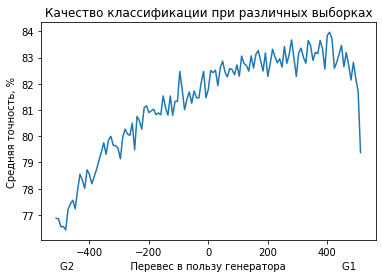

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Качество классификации при различных выборках')
plt.xlabel('G2                  Перевес в пользу генератора                  G1')
plt.ylabel('Средняя точность, %')
plt.plot(np.arange(-64, 65) * 8, np.flip(accs.mean(axis=2).mean(axis=1)))
plt.savefig('2.png')

In [66]:
accs = np.load('Accs/2/accsOffsFull5shot.npy')
accs.shape

(129, 32, 16)

In [68]:
accuracies = accs.mean(axis=2).mean(axis=1)
accuracies[np.where(accuracies > 82.5)].mean()

83.0298828125

In [72]:
accuracies[128]

76.873046875